In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

nltk.download('punkt')


from sklearn.pipeline import make_pipeline
import time



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
pip install emoji



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordsegment


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install contractions


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Data loading using chunk size

reviews = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=20000)

# Iterate through chunks and process each one
chunk_list = []
for chunk in reviews:
    chunk_list.append(chunk)
    
# Concatenate the chunks after reading
reviews_df = pd.concat(chunk_list, ignore_index=True)


In [7]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
reviews_df.shape

(6990280, 9)

In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


In [10]:
reviews_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

# Target Variable creation

In [12]:

# Creating the target variable (Positive, Negative, Neutral)
def label_review(stars):
    if stars >= 4:
        return '1'   # positive
    elif stars <= 2:
        return '-1'  # negative
    else:
        return '0'   # Neutral


reviews_df['sentiment'] = reviews_df['stars'].apply(label_review)

reviews_df.head()



,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1


# Preprocessing the 'text' columns
1. lowercasing
2. removing punctuation
3. Removing stop words
4. Negation handling  - Not, No, Never, None, n't
5. Expanding Contractions
6. Handling abbrevations
7. removing emojis and hashtags
8. Tokenization
9. Stemming - reducing the word to base form
gs

In [13]:
# Sampling 3% of the data
sampled_reviews = reviews_df.sample(frac=0.03, random_state=42)  


print(f"Sampled data size: {sampled_reviews.shape}")


Sampled data size: (209708, 10)


In [14]:
import re
import emoji
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordsegment import load, segment
import contractions  
import abbr  


load()


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def expand_contractions(text):
    
    return contractions.fix(text)



def clean_hashtags(text):
    
    hashtags = re.findall(r'#\w+', text)
    for hashtag in hashtags:
        words = ' '.join(segment(hashtag[1:]))  
        text = text.replace(hashtag, words)
    return text

def handle_negation(text):
    
    negation_patterns = re.compile(r'\b(?:not|no|never|none|n\'t)\b[\w\s]+[^\w\s]')
    return negation_patterns.sub(lambda match: '_'.join(match.group(0).split()), text)

def clean_text(text):
   
    # lowercase
    text = text.lower()

    # Expanding contractions
    text = expand_contractions(text)
    

    # negation
    text = handle_negation(text)

    # hashtags
    text = clean_hashtags(text)

    # emojis
    text = emoji.demojize(text)

    # punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)






sampled_reviews['final_cleaned_text'] = sampled_reviews['text'].apply(clean_text)



sampled_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,final_cleaned_text
1295256,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53,-1,went lunch found burger meh obviou focu burger...
3297618,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14,1,need new tire wife car special order next day ...
1217795,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48,1,jim woltman work goleta honda 5 star knowledg ...
3730348,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49,1,time get shrimp got nice select differ fish pr...
1826590,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25,1,one fantast place eat whether hungri need good...


In [15]:
sampled_reviews.reset_index(drop=True, inplace=True)

In [16]:
sampled_reviews.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,final_cleaned_text
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53,-1,went lunch found burger meh obviou focu burger...
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14,1,need new tire wife car special order next day ...
2,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48,1,jim woltman work goleta honda 5 star knowledg ...
3,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49,1,time get shrimp got nice select differ fish pr...
4,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25,1,one fantast place eat whether hungri need good...
5,18E_haOfOm8ks-A7SlVWRg,bnDZpsii_if2_wpn8oPcig,bK0j7YtVyN98UnM_8fUONg,3,1,1,1,Dirt cheap happy hour specials. Half priced d...,2011-11-08 01:30:27,0,dirt cheap happi hour special half price drink...
6,8rD5LvgHVPSnyyae4ji4dA,YxpJDf6Idn7MA9E003B0Zw,zLIrhVc1nfPTOF33eFD4_g,1,4,1,0,"Unbelievably poor customer ""service"". Beyond ...",2011-05-15 22:58:44,-1,unbeliev poor custom servic beyond bad insist ...
7,hYYN8bWKRW29qqdpaKOdMg,8H183Gq4be1PqKBW7jbIiA,KHl171eshtTPrGyBWGEHQQ,5,1,0,0,I walked in the door and was greeted with a we...,2015-05-24 11:48:33,1,walk door greet welcom smile offer help find g...
8,xQVDB9xRdpLmPh9XMQ6Gvg,yy38DH7ENFTJ10-d4GUlig,S26FJcC298XNpN2cZiwOrA,5,0,0,0,Nothing beats pizza and beer in my book. This ...,2012-12-24 02:18:18,1,noth beat pizza beer book place nail eye towar...
9,c7IQ5alG0pl9yCITtsIlrA,ZLKpeCqbCMWfNeT6yU8wUQ,zT2OzXDWKK1abapHs2RUrQ,5,1,0,0,Philly cheese steak (loaded) was phenomenal. ...,2021-07-02 02:17:40,1,philli chees steak load phenomen good servic v...


In [17]:
sampled_reviews.shape

(209708, 11)

# Train-test split

In [18]:

x_train, x_test, y_train, y_test = train_test_split(sampled_reviews['final_cleaned_text'], sampled_reviews['sentiment'], test_size=0.2, stratify=sampled_reviews['sentiment'], random_state=42)


print(y_train.value_counts())

sentiment
1     112467
-1     38654
0      16645
Name: count, dtype: int64


In [19]:
x_train.head

<bound method NDFrame.head of 181428    best pizza st pete opinion kind upset took lon...
32644     first thing need know pinewood social extrem i...
55173     food pretti good got meal grill beyond eat not...
204776    flowmast 44 put charger right bought figur bou...
73757     got number 11 omg sam made tast differ 30 year...
                                ...                        
112375    hi tri today buisi clean good servic food not_...
84605     spent 5 year philli share cheesesteak enjoy pa...
178864    use eat time howev last visit walk front entra...
164703    chick fil food good consist lunch encount toda...
161646    staff friendli way around think clearwat much ...
Name: final_cleaned_text, Length: 167766, dtype: object>

# saving files

In [18]:
# x_train.to_csv( 'x_train_ml2',index=False)
# y_train.to_csv( 'y_train_ml2',index=False)
# x_test.to_csv('x_test_ml2',index=False)
# y_test.to_csv('y_test_ml2',index=False)

# Vectorization -  Unigram Count Vectorizer

In [20]:

count_vectorizer_unigram = CountVectorizer(ngram_range=(1, 1), max_features=5000, max_df=0.9,min_df=5)


x_train_count_unigram = count_vectorizer_unigram.fit_transform(x_train)
x_test_count_unigram = count_vectorizer_unigram.transform(x_test)


In [21]:
x_train_count_unigram.shape

(167766, 5000)

In [22]:

feature_names = count_vectorizer_unigram.get_feature_names_out()

x_train_count_unigram_df = pd.DataFrame(x_train_count_unigram.toarray(), columns=feature_names)


x_train_count_unigram_df.head()


,10,100,1000,1010,1015,1030,10am,10pm,10th,11,...,yr,yuck,yum,yummi,yup,zero,zip,zone,zoo,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# One-Hot Unigram Vectorizer 

In [23]:

one_hot_vectorizer_unigram = CountVectorizer(ngram_range=(1, 1), binary=True,max_features=5000)


x_train_onehot_unigram = one_hot_vectorizer_unigram.fit_transform(x_train)
x_test_onehot_unigram = one_hot_vectorizer_unigram.transform(x_test)


# Class separability check on Unigram Count vectorizer 


In [24]:
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import numpy as np





ipca = IncrementalPCA(n_components=2)

batch_size = 1000


for i in range(0, x_train_count_unigram.shape[0], batch_size):
    ipca.partial_fit(x_train_count_unigram[i:i + batch_size].toarray())


x_train_pca = np.empty((x_train_count_unigram.shape[0], 2))

for i in range(0, x_train_count_unigram.shape[0], batch_size):
    x_train_pca[i:i + batch_size] = ipca.transform(x_train_count_unigram[i:i + batch_size].toarray())



Mapped unique values after conversion: [2 0 1]


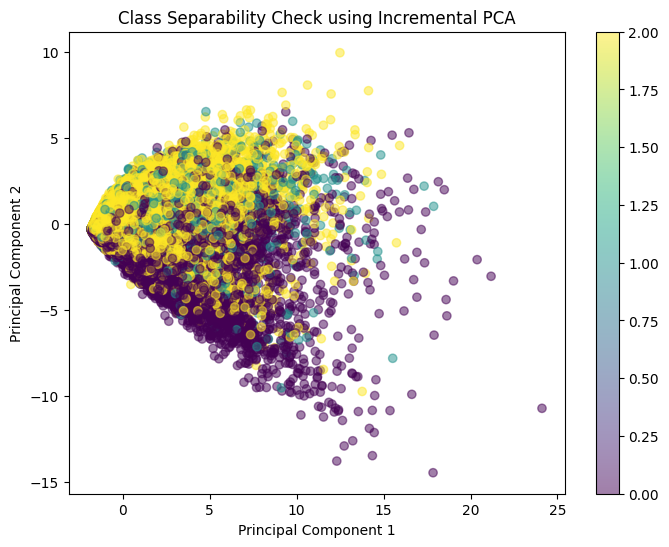

In [25]:

y_train_numeric = pd.to_numeric(y_train, errors='coerce')  


color_map = {1: 2, 0: 1, -1: 0} 
y_train_mapped = y_train_numeric.map(color_map)


print("Mapped unique values after conversion:", y_train_mapped.unique())


if y_train_mapped.isnull().any():
    print("Warning: There are NaN values in y_train_mapped.")


plt.figure(figsize=(8, 6))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_mapped, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Class Separability Check using Incremental PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Numerical Features
1. Cool
2. useful

# Run below cell after vectorization for adding above mentioned features

In [26]:

from scipy.sparse import hstack


x_train_combined = hstack([
    x_train_count_unigram,
    sampled_reviews.loc[x_train.index, ['useful', 'cool']].values
])

x_test_combined = hstack([
    x_test_count_unigram,
    sampled_reviews.loc[x_test.index, ['useful', 'cool']].values
])


In [27]:
print(x_train_combined.shape)
print(x_test_combined.shape)

(167766, 5002)
(41942, 5002)



# 1.Before Splitting data

 1. Data loading and initial exploration
 2. Sampled 3% of data 
 3. Data cleaning (handling of negations, stop words, stemming, contractions)

  

# 2.Train and Test Split

# 3.Vectorization 
Did
1. Unigram count vectorization
2. please apply different vectorization techniques according to your tasks and assignment.


# 3.Class Separability 
1. For Unigram count vectorizer, class seperability is not that good.


# 4.Numerical Features Added

1. cool
2. useful


# 5.Feature Set with Best Separability

Need to do unigram + bigram 


# Naive Bayes Model With One-Hot-Vectors

In [28]:

# Sample text for one hot encoding
sample_for_onehot = sampled_reviews['final_cleaned_text'][:20000]


In [30]:

# Reshape the sample_for_onehot to an array
nb_all_words_array = np.array(sample_for_onehot).reshape(-1,1)

In [31]:
# Initialize one-hot encoder and fit it to the unique words
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

nb_encoder = OneHotEncoder(sparse_output = False)
nb_encoder.fit(nb_all_words_array)

OneHotEncoder(sparse_output=False)

In [32]:
# Encode each sentence into a one hot vector
nb_ohe_texts = \
[nb_encoder.transform(np.array(sentence).reshape(-1,1)).sum(axis=0) for sentence in nb_all_words_array] 

In [33]:
# Define the feature 
nbX = np.array(nb_ohe_texts)


In [34]:
# Define the label
nby = sampled_reviews['sentiment'][:20000]

In [35]:
# Split the data to train and test sets
nb_train, nb_test, nby_train, nby_test = train_test_split(nbX, nby, test_size=0.3, random_state=42)

In [47]:
# Train the Naive Bayes model with Laplace smoothing
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(nb_train, nby_train)

# Make Predictions and evaluate
nby_pred = nb_model.predict(nb_test)
nb_accuracy = accuracy_score(nby_test, nby_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy}')
print("Classification Report: ", classification_report(nby_test, nby_pred))

Naive Bayes Accuracy: 0.6715
Classification Report:                precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1386
           0       0.00      0.00      0.00       585
           1       0.67      1.00      0.80      4029

    accuracy                           0.67      6000
   macro avg       0.22      0.33      0.27      6000
weighted avg       0.45      0.67      0.54      6000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [38]:
# Determine training time 

Import timeit

# Function to check how long the model trains
def nb_train_model():
    # Train the Naive Bayes model with Laplace smoothing
    nb_model = MultinomialNB(alpha=1.0)
    nb_model.fit(nb_train, nby_train)

# Check execution time
exec_time = timeit.timeit(nb_train_model, number=10) #10 iterations for average timing
avg_time = exec_time/10
print(f'Average train time of the Naive Bayes model: {avg_time: .4f} seconds')

Average train time of the Naive Bayes model:  1.3830 seconds


# Naive Bayes With Unigram + Bigram

In [40]:
from sklearn.metrics import classification_report

# Create CountVectorizer with unigram and bigram
nb_vec = CountVectorizer(ngram_range=(1,2))

# Leveraging the same sample data used for OHE
nb_vecX = nb_vec.fit_transform(sample_for_onehot)


In [41]:
# Train - test split
nb_train1, nb_test1, nby_train1, nby_test1 = train_test_split(nb_vecX, nby, test_size=0.3, random_state=42)

In [42]:
# Train the Naive Bayes model
nb_model1 = MultinomialNB()
nb_model1.fit(nb_train1, nby_train1)

MultinomialNB()

In [43]:
# Predict using nb_test1
nby_pred1 = nb_model1.predict(nb_test1)

# Model evaluation
print("Accuracy for Naive Bayes with ngrams: ", accuracy_score(nby_test1, nby_pred1))
print("Classification Report: ", classification_report(nby_test1, nby_pred1))


Accuracy for Naive Bayes with ngrams:  0.8213333333333334
Classification Report:                precision    recall  f1-score   support

          -1       0.84      0.72      0.77      1386
           0       0.25      0.00      0.00       585
           1       0.82      0.98      0.89      4029

    accuracy                           0.82      6000
   macro avg       0.64      0.57      0.56      6000
weighted avg       0.77      0.82      0.78      6000



In [46]:
# Determine training time 

# Function to check how long the model trains
def nb_train_model1():
    # Train the Naive Bayes model with Laplace smoothing
    nb_model1 = MultinomialNB()
    nb_model1.fit(nb_train1, nby_train1)

# Check execution time
exec_time1 = timeit.timeit(nb_train_model1, number=10) #10 iterations for average timing
avg_time1 = exec_time1/10
print(f'Average train time of the Naive Bayes model with unigram and bigram: {avg_time1: .4f} seconds')

Average train time of the Naive Bayes model with unigram and bigram:  0.0374 seconds


##### CountVectorizer yields a higher accuracy than One Hot Vector, and is over 37 times faster.

### Tuning Naive Bayes (unigram + bigram)

In [48]:
# Tune the Naive Bayes model
nb_model1 = MultinomialNB(alpha=0.8)
nb_model1.fit(nb_train1, nby_train1)
# Predict using nb_test1
nby_pred1 = nb_model1.predict(nb_test1)

# Model evaluation
print("Accuracy at alpha = 0.8: ", accuracy_score(nby_test1, nby_pred1))
print("Classification Report at alpha = 0.8: ", classification_report(nby_test1, nby_pred1))

Accuracy at alpha = 0.8:  0.8253333333333334
Classification Report at alpha = 0.8:                precision    recall  f1-score   support

          -1       0.81      0.76      0.78      1386
           0       0.38      0.01      0.02       585
           1       0.83      0.97      0.89      4029

    accuracy                           0.83      6000
   macro avg       0.67      0.58      0.57      6000
weighted avg       0.78      0.83      0.78      6000



Recall and precision for the negative sentiment improved at alpha of 0.8; accuracy improved slightly.

Possible next steps for Naive Bayes include:
1. Using Trigrams
2. Feature selection
3. Using ensemble techniques
4. Cross validation for model selection
5. Use of TfidfVectorizer instead of CountVectorizer. TfidfVectorizer places more emphasis on important words

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Load the Dataset
# Load the CSV file you provided
data = pd.read_csv('processed_dataset.csv')

# Display the first few rows to understand the structure
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
                review_id                 user_id             business_id  \
0  J5Q1gH4ACCj6CtQG7Yom7g  56gL9KEJNHiSDUoyjk2o3Q  8yR12PNSMo6FBYx1u5KPlw   
1  HlXP79ecTquSVXmjM10QxQ  bAt9OUFX9ZRgGLCXG22UmA  pBNucviUkNsiqhJv5IFpjg   
2  JBBULrjyGx6vHto2osk_CQ  NRHPcLq2vGWqgqwVugSgnQ  8sf9kv6O4GgEb0j1o22N1g   
3  U9-43s8YUl6GWBFCpxUGEw  PAxc0qpqt5c2kA0rjDFFAg  XwepyB7KjJ-XGJf0vKc6Vg   
4  8T8EGa_4Cj12M6w8vRgUsQ  BqPR1Dp5Rb_QYs9_fz9RiA  prm5wvpp0OHJBlrvTj9uOg   

   stars  useful  funny  cool  \
0      2       1      0     0   
1      5       0      0     0   
2      5       0      0     0   
3      4       0      0     0   
4      5       0      0     0   

                                                text                 date  \
0  Went for lunch and found that my burger was me...  2018-04-04 21:09:53   
1  I needed a new tires for my wife's car. They h...  2020-05-24 12:22:14   
2  Jim Woltman who works at Goleta Honda is 5 sta...  2019-02-14 03:47:48   

In [9]:
# Evaluating the Model

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

# AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Plot ROC Curve
plt.plot(fpr, tpr, marker='.')
plt.title(f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# F1 Score for Positive and Negative Classes
f1_positive = f1_score(y_test, y_pred, pos_label=1)
f1_negative = f1_score(y_test, y_pred, pos_label=0)
print(f"F1 Score for Positive Class: {f1_positive:.4f}")
print(f"F1 Score for Negative Class: {f1_negative:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:


NameError: name 'y_test' is not defined